# Introduction

In this notebook we build a CycleGAN (Generative Adversarial Network) model to translate real landscape photos into the style of Claude Monet. 

Here we have built a simplified version of the model given in the TensorFlow [CycleGAN](https://www.tensorflow.org/tutorials/generative/cyclegan) and [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix) tutorials. Additionally, we referenced the Kaggle [Monet CycleGAN](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook) tutorial for the input and submission portions of this notebook.

GitHub location: https://github.com/beha9089/DTSA5511_CycleGan

In [13]:
import os
import time
import PIL
import shutil
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from kaggle_datasets import KaggleDatasets

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.12.0


# Preparing the Data

In [14]:
data_path = KaggleDatasets().get_gcs_path()

filenames_monet = tf.io.gfile.glob(str(data_path + '/monet_tfrec/*.tfrec'))
filenames_photo = tf.io.gfile.glob(str(data_path + '/photo_tfrec/*.tfrec'))

Here we define the functions that will read the TFRecord files, normalize/transform the images, and return a TensorFlow dataset. The functions random_jitter and normalize transform the image and are called in the preprocess function, with the former only being called when building a training dataset. The only function below called directly by us is the final defined, load_dataset.

In [15]:
image_size = [256, 256]
output_channels = 3


def random_jitter(image):
    # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)    
    # randomly cropping to 256 x 256 x 3
    image = tf.image.random_crop(image, size = [image_size[0], image_size[1], output_channels])
    # random mirroring
    image = tf.image.random_flip_left_right(image)
    return image

def normalize(image):
    # Normalize the pixel values to [-1, 1]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def preprocess_image(example, training):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = tf.image.decode_jpeg(example['image'], channels = output_channels)
    
    # Only call the random_jitter function if the data are for training
    if training:
        image = random_jitter(image)
    # Normalize the image
    image = normalize(image)
    return image


# Define two help functions, one for each of the model training and testing scenarios
def read_tfrecord_train(example):
    image = preprocess_image(example, True)
    return image

def read_tfrecord_test(example):
    image = preprocess_image(example, False)
    return image

# Define the function that we will call to load data
def load_dataset(filenames, training):
    dataset = tf.data.TFRecordDataset(filenames)
    if training:
        dataset = dataset.map(read_tfrecord_train, num_parallel_calls = AUTOTUNE)
    else:
        dataset = dataset.map(read_tfrecord_test, num_parallel_calls = AUTOTUNE)
    return dataset

In [16]:
# Create train datasets of monet and landscape images
monet_ds = load_dataset(filenames_monet, True).batch(1)
photo_ds = load_dataset(filenames_photo, True).batch(1)

print(f'There are {len(list(monet_ds))} Monet images in the training data')
print(f'There are {len(list(photo_ds))} landscape images in the training data')

There are 300 Monet images in the training data
There are 7038 landscape images in the training data


Below we get examples from each dataset and visualize them.

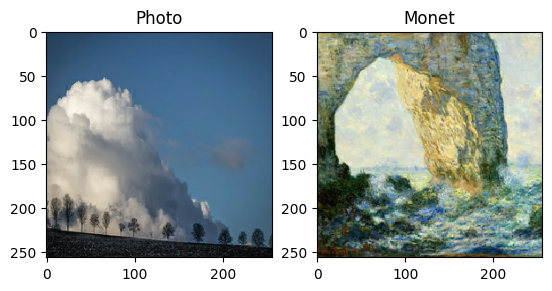

In [17]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

# Building the Models

## Define the Models

### Encoder and Decoder
Below we define the encoder and decoder models, which form the basis of our generator and discriminator models. These will be layered into decoder and encoder stacks within the generator and the discriminator will utilize a stack of encoder models.

The encoder is a sequential model consisting of a convolution, an instance normalization, and a leaky ReLU activation. We add each of these components one at a time, which enables the normalization layer to be an optional addition.

The decoder is also a sequential model. It consists of a convolution, an instance normalization, a dropout, and a leaky ReLU. Again we add each layer one at a time to enable conditional layers. Here the normalization is always applied and the dropout is an optional layer.

As in the U-Net model there will be skip connections between the encoder and decoder within the generator.

In [37]:
def encoder(filters, size, apply_norm = True):
    initializer = tf.random_normal_initializer(0.0, 0.02)
    
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides = 2, padding = 'same', kernel_initializer = initializer, use_bias = True))
    
    if apply_norm:
        result.add(layers.GroupNormalization(groups = -1))
    
    result.add(layers.LeakyReLU())
    return result


def decoder(filters, size, apply_dropout = False):
    initializer = tf.random_normal_initializer(0.0, 0.02)
    
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides = 2, padding = 'same', kernel_initializer = initializer, use_bias = True))
    result.add(layers.GroupNormalization(groups = -1))
    if apply_dropout:
        result.add(layers.Dropout(0.5))
        
    result.add(layers.ReLU())
    
    return result

### Generator

As mentioned above, our generator is a modified U-Net, which consists of encode and decode stacks with skip connections between these layers. 

In [38]:
def generator():    
    
    encode_stack = [
        encoder(16, 4, apply_norm = False),  
        encoder(32, 4, apply_norm = True),  
        encoder(64, 4, apply_norm = True),  
        encoder(128, 4, apply_norm = True), 
        encoder(128, 4, apply_norm = True), 
        ]
    
    decode_stack = [
        decoder(128, 4, apply_dropout = True),
        decoder(128, 4, apply_dropout = True),
        decoder(64, 4, apply_dropout = True), 
        decoder(32, 4, apply_dropout = False),
        decoder(16, 4, apply_dropout = False),
        ]
    
    initializer = tf.random_normal_initializer(0.0, 0.02)
    last = layers.Conv2DTranspose(output_channels, 4, strides = 2, padding = 'same', kernel_initializer = initializer, activation = 'tanh')
    
    inputs = layers.Input(shape = [image_size[0], image_size[1], output_channels])
    x = inputs
    
    # Move through the encode stack, define the skips list
    skips = []
    for encode in encode_stack:
        x = encode(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    # Move through the decode stack and create the skip connections
    for decode, skip in zip(decode_stack, skips):
        x = decode(x)
        x = layers.Concatenate()([x, skip])
        
    x = last(x)
    
    return tf.keras.Model(inputs = inputs, outputs = x)

### Discriminator
The descriminator consists of three encoder layers, a padding layer, a convolution, an instance normalization, a leaky ReLU, and then a further padding and convolution.

In [39]:
# Define
def discriminator():
    initializer = tf.random_normal_initializer(0.0, 0.02)
    
    inpt = layers.Input(shape = [image_size[0], image_size[1], 3], name = 'input_image')
    x = inpt
    
    encode1 = encoder(32, 4, False)(x)
    encode2 = encoder(64, 4, True)(encode1)
    encode3 = encoder(128, 4, True)(encode2)
    
    zero_pad1 = layers.ZeroPadding2D()(encode3)
    conv = layers.Conv2D(256, 4, strides = 1, kernel_initializer = initializer, use_bias = False)(zero_pad1)
    
    norm1 = layers.GroupNormalization(groups = -1)(conv)
        
    leaky_relu = layers.LeakyReLU()(norm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) 
    last = layers.Conv2D(1, 4, strides = 1, kernel_initializer = initializer)(zero_pad2)
    
    return tf.keras.Model(inputs = inpt, outputs = last)

## Loss Functions

The loss functions below all implement a binary crossentropy loss. In brief, each function represents the following

* generator_loss: Computes how well the image faked by the generator fooled the discriminator. Takes as input the output of the discriminator evaluated on a faked image.

* discriminator_loss: Computes how well the discriminator can differentiate between real and faked images. Takes as input two discriminator outputs, one of a real image and one of a faked image.

* calc_cycle_loss: How different is a cycled image from the original image. For example, if we morph a photo into a Monet and then back to a photo, how different is the reconstructed photo from the original photo.

* identity_loss: How much transformation does our generator apply to an image that should not be transformed. For example, if we pass a Monet image through the Monet generator we would want the resulting image to be the same or very close to the original.

In [40]:
LAMBDA = 10
loss_func = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def generator_loss(generated):    
    return loss_func(tf.ones_like(generated), generated)

def discriminator_loss(discrim_real_output, discrim_gen_output):
    real_loss = loss_func(tf.ones_like(discrim_real_output), discrim_real_output)
    
    generated_loss = loss_func(tf.zeros_like(discrim_gen_output), discrim_gen_output)
    
    total_discrim_loss = real_loss + generated_loss    
    return 0.5*total_discrim_loss

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

## Instantiate

Now that we have built the models and defined the loss functions, the last step before moving forward to training is to instantiate model objects and associated optimizers.

### Instantiate Generators and Discriminators
We instantiate two generators and two discriminators. The Monet generator and discriminator will be trained to generate Monet images from photos and differentiate real Monet images from faked ones. The photo generator and discriminator are defined analogously.

In [41]:
# Instantiate generators
monet_generator = generator() # Takes a photo and generates a Monet
photo_generator = generator() # Takes a Monet and generates a photo
# Instantiate discriminators
monet_discriminator = discriminator()
photo_discriminator = discriminator()

### Instantiate Optimizers for Generators and Discriminators
We define optimizers for each of the generator and discriminator models. These will be how we apply our calculated gradients during training.

In [42]:
lr = 2e-4
beta = 0.5

# Create optimizers for the generators
monet_generator_optim = tf.keras.optimizers.Adam(lr, beta_1 = beta)
photo_generator_optim = tf.keras.optimizers.Adam(lr, beta_1 = beta)
# Create optimizers for the discriminators
monet_discriminator_optim = tf.keras.optimizers.Adam(lr, beta_1 = beta)
photo_discriminator_optim = tf.keras.optimizers.Adam(lr, beta_1 = beta)

## Preview Model Output
Below we preview the output of our untrained generator and discriminator models. We can see that both generators simply produce noise when fed an example image. The same is true for our discriminators.

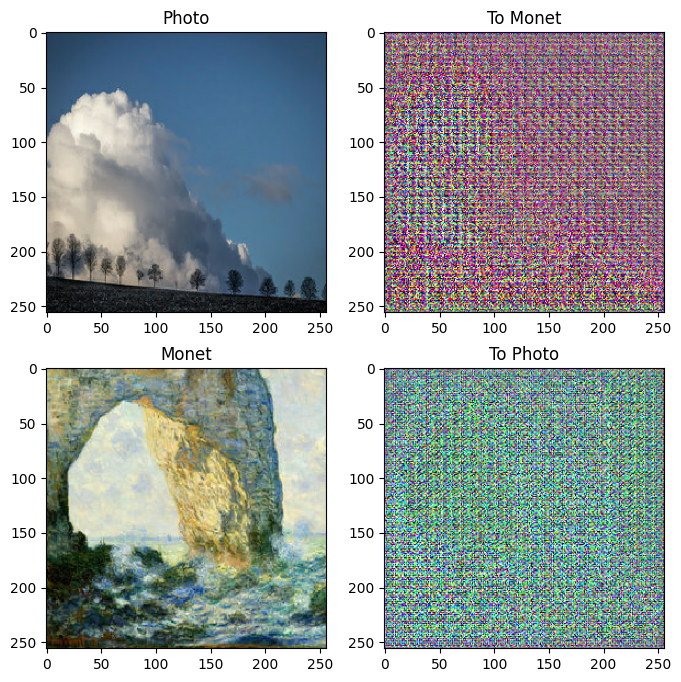

In [43]:
# Fake a Monet
to_monet = monet_generator(example_photo)
# Fake a photo
to_photo = photo_generator(example_monet)

plt.figure(figsize=(8, 8))
contrast = 8

imgs = [example_photo, to_monet, example_monet, to_photo]
title = ['Photo', 'To Monet', 'Monet', 'To Photo']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
        
plt.show()

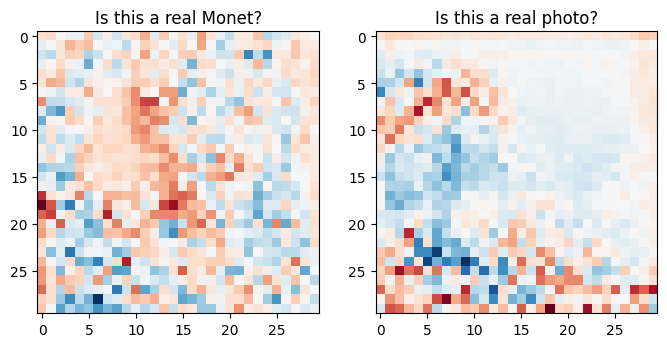

In [44]:
plt.figure(figsize=(8, 8))

# Feed the example Monet into the discriminator
plt.subplot(121)
plt.title('Is this a real Monet?')
plt.imshow(monet_discriminator(example_monet)[0, ..., -1], cmap='RdBu_r')

# Feed the example photo into the photo discriminator
plt.subplot(122)
plt.title('Is this a real photo?')
plt.imshow(photo_discriminator(example_photo)[0, ..., -1], cmap='RdBu_r')

plt.show()

# Model Training

Now we can train our model, consisting of two generators and two discriminators. 

## Define the Training Step
Below we define the train_step function, which we will call once per image per epoch. Each training step consists of 

1) Generate images (real to fake, fake to real (cycled), and real to real (same))

2) Discriminate images (pass the real and fake images through the appropriate discriminator)

3) Calculate losses

4) Calculate gradients for each generator and discriminator

5) Apply the gradients to update weights

In [45]:
@tf.function
def train_step(real_p, real_m):
    with tf.GradientTape(persistent = True) as tape:
        
        ### Generate images ###
        
        # Generate a fake Monet from a real photo and cycle it back to a photo
        fake_m = monet_generator(real_p, training = True)
        cycled_p = photo_generator(fake_m, training = True)
        
        # Generate a fake photo from a real Monet and cycle it back to a Monet
        fake_p = photo_generator(real_m, training = True)
        cycled_m = monet_generator(fake_p, training = True)
        
        # Generate a photo/Monet from a real photo/Monet
        same_p = photo_generator(real_p, training = True)
        same_m = monet_generator(real_m, training = True)
        
        
        ### Pass real and generated images through discriminators ###
        
        # Pass a real photo/Monet through the photo/Monet discriminator
        disc_real_p = photo_discriminator(real_p, training = True)
        disc_real_m = monet_discriminator(real_m, training = True)
        
        # Pass a fake photo/Monet through the photo/Monet discriminator
        disc_fake_p = photo_discriminator(fake_p, training = True)
        disc_fake_m = monet_discriminator(fake_m, training = True)
        
        
        ### Calculate losses ###
        
        # Calculate the total cycle loss by comparing the real and cycled images
        total_cycle_loss = calc_cycle_loss(real_p, cycled_p) + calc_cycle_loss(real_m, cycled_m)
        
        # Calculate the loss from the generator (i.e., how good is each at fooling the discriminator)
        monet_gen_loss = generator_loss(disc_fake_m)
        photo_gen_loss = generator_loss(disc_fake_p)       
        
        # Calculate the total generator loss (equal to adversarial loss + cycle loss)
        total_monet_gen_loss = monet_gen_loss + total_cycle_loss + identity_loss(real_m, same_m)
        total_photo_gen_loss = photo_gen_loss + total_cycle_loss + identity_loss(real_p, same_p)
        
        # Calculate the loss on the discriminator (i.e., how good is each at discerning real from fake)
        photo_disc_loss = discriminator_loss(disc_real_p, disc_fake_p)
        monet_disc_loss = discriminator_loss(disc_real_m, disc_fake_m)
        
        
    ### Calculate gradients ###
        
    # Calculate the gradients for the generators
    monet_generator_gradients = tape.gradient(total_monet_gen_loss, monet_generator.trainable_variables)
    photo_generator_gradients = tape.gradient(total_photo_gen_loss, photo_generator.trainable_variables)
        
    # Calculate the gradients for the discriminators
    photo_discriminator_gradients = tape.gradient(photo_disc_loss, photo_discriminator.trainable_variables)
    monet_discriminator_gradients = tape.gradient(monet_disc_loss, monet_discriminator.trainable_variables)
        
    ### Apply the gradients ###
        
    # Apply the gradients to the optimizers
    monet_generator_optim.apply_gradients(zip(monet_generator_gradients, monet_generator.trainable_variables))        
    photo_generator_optim.apply_gradients(zip(photo_generator_gradients, photo_generator.trainable_variables))
        
    # Apply the gradients to the discriminators
    photo_discriminator_optim.apply_gradients(zip(photo_discriminator_gradients, photo_discriminator.trainable_variables))        
    monet_discriminator_optim.apply_gradients(zip(monet_discriminator_gradients, monet_discriminator.trainable_variables))

## Train the Model
Pass each pair of images through the training function, repeating for each epoch. Note that because the Monet dataset consists of only 300 images, the zipped pairing consists of only 300 images as well.

In [46]:
EPOCHS = 25
for epoch in range(EPOCHS):
    start = time.time()    
    n = 0
    for image_p, image_m in tf.data.Dataset.zip((photo_ds, monet_ds)):
        train_step(image_p, image_m)
        if n % 10 == 0:
            print ('.', end = '')
        n += 1
    
    print(f'Time taken for epoch {epoch + 1} is {time.time()-start} sec\n')

2023-10-07 21:03:11.978330: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/model_8/sequential_59/dropout_14/dropout_2/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


..............................Time taken for epoch 1 is 49.41998887062073 sec

..............................Time taken for epoch 2 is 16.952300786972046 sec

..............................Time taken for epoch 3 is 17.172382354736328 sec

..............................Time taken for epoch 4 is 16.60024905204773 sec

..............................Time taken for epoch 5 is 17.18096137046814 sec

..............................Time taken for epoch 6 is 17.70156240463257 sec

..............................Time taken for epoch 7 is 16.710703134536743 sec

..............................Time taken for epoch 8 is 17.141451358795166 sec

..............................Time taken for epoch 9 is 16.664093255996704 sec

..............................Time taken for epoch 10 is 17.255792379379272 sec

..............................Time taken for epoch 11 is 16.630800247192383 sec

..............................Time taken for epoch 12 is 16.98859214782715 sec

..............................Time taken f

## Visualize Output

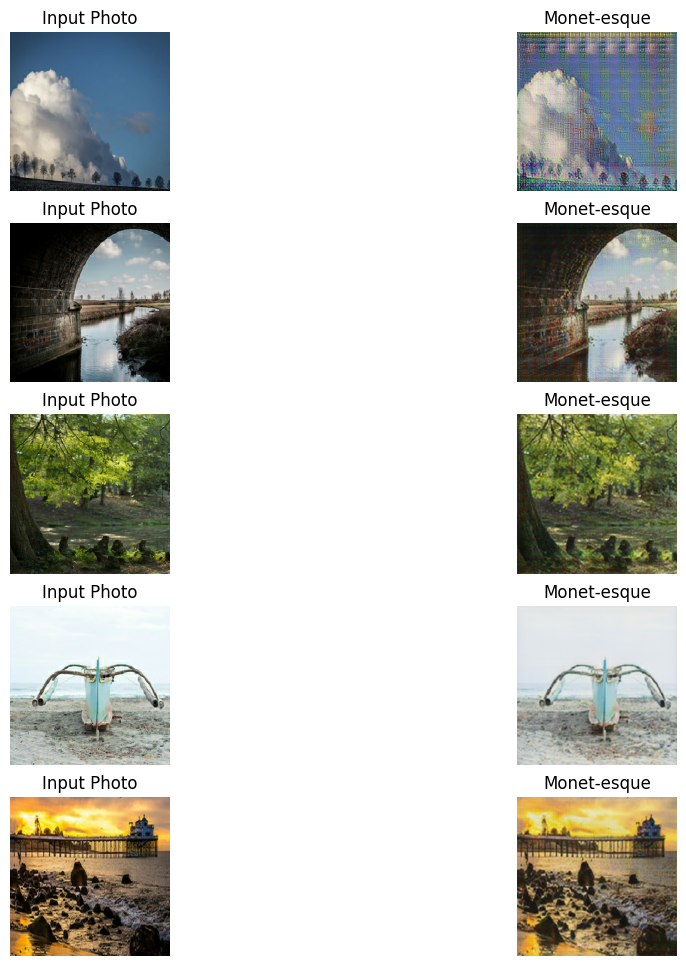

In [47]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training = False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Submit Monet-ified Photos

Below we define a training photo dataset and pass each image through our trained Monet generator. We store the resulting images in a zip file in the working directory.

In [ ]:
# Make a directory to store the submission file
! mkdir ../images
# Recreate the photo data set for predictions (without random jittering)
photo_ds = load_dataset(filenames_photo, False).batch(1)
# Loop through the photos and store the predictions
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training = False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

# Write the archive
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")